# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.124514,True,5.693451
1,-0.292190,True,4.062787
2,-1.385958,True,2.714415
3,-0.995467,True,2.267715
4,-0.823737,True,2.338058
...,...,...,...
995,-1.872320,True,0.520660
996,0.784960,False,0.398467
997,0.077604,True,3.799712
998,-0.140023,True,3.908738


<AxesSubplot:xlabel='v0'>

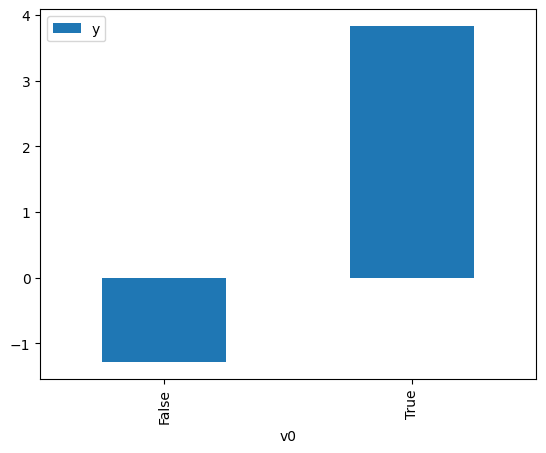

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

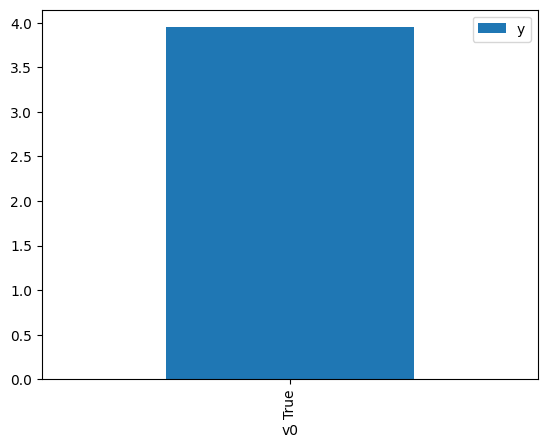

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.230069,False,-1.092803,0.493784,2.025179
1,0.190424,False,-0.075805,0.448052,2.231885
2,0.041121,False,-0.459379,0.464229,2.154108
3,-0.742064,False,-1.240707,0.549532,1.819730
4,-2.511871,False,-3.947875,0.725491,1.378378
...,...,...,...,...,...
995,0.992927,False,2.332542,0.363757,2.749084
996,0.371767,False,1.659599,0.428553,2.333436
997,-0.325569,False,0.026338,0.504212,1.983292
998,-1.525208,False,-2.237504,0.632015,1.582241


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.131385,True,2.792901,0.408821,2.446060
1,-1.123238,True,3.470913,0.409681,2.440923
2,0.171730,True,4.131344,0.549928,1.818420
3,-0.953112,True,1.658473,0.427766,2.337725
4,-1.416675,True,1.341590,0.379078,2.637977
...,...,...,...,...,...
995,-0.039701,True,3.782035,0.526980,1.897607
996,-0.709182,True,3.387374,0.454026,2.202518
997,-0.072334,True,5.101251,0.523425,1.910494
998,-0.925324,True,2.901228,0.430740,2.321585


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              7492.
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        17:56:58   Log-Likelihood:                         -1378.3
No. Observations:                1000   AIC:                                      2761.
Df Residuals:                     998   BIC:                                      2770.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0291      0.027     75.872      0.000       1.977       2.082
x2             4.9900      0.045    109.905      0.000       4.901       5.079
==============================================================================
Omnibus:                        0.864   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.649   Jarque-Bera (JB):                0.844
Skew:                           0.071   Prob(JB):                        0.656
Kurtosis:                       2.998   Cond. No.                         1.78
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""